In [36]:
import os 

import torch
import matplotlib as mpl
import matplotlib.pyplot as plt

import vari
import vari.datasets
import vari.models
import vari.inference
import vari.layers

In [37]:
experiments_dir = '/nas/experiments/sacred/models/'

## Visualize dataset

In [38]:
train_dataset = vari.datasets.Spirals(n_samples=10000)
x_train = train_dataset.examples
y_train = train_dataset.labels
y_train = np.argmax(y_train, -1)
y_train_onehot = np.eye(2)[y_train]

In [39]:
# Meshgrid for spiral data
nx, ny = (50, 50)
x = np.linspace(np.min(x_train[:,0]), np.max(x_train[:,0]), nx)
y = np.linspace(np.min(x_train[:,1]), np.max(x_train[:,1]), ny)
xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
x_meshgrid = []
for i in range(nx):   
    for j in range(ny):
        x_meshgrid += [[xv[j,i], yv[j,i]]]
        if not i == 0:
            x_meshgrid += [[xv[j,i-1], yv[j,i-1]]]
        x_meshgrid += [[xv[j,i], yv[j,i]]]
        if not j == 0:
            x_meshgrid += [[xv[j-1,i], yv[j-1,i]]]
        x_meshgrid += [[xv[j,i], yv[j,i]]]
        if j == ny-1:
            for k in range(ny):
                x_meshgrid += [[xv[ny-(k+1),i], yv[ny-(k+1),i]]]

x_train_meshgrid = np.array(x_meshgrid)

In [110]:
# Meshgrid for spiral data
nx, ny = (100, 100)
x = np.linspace(np.min(x_train[:,0]) - 1, np.max(x_train[:,0]) + 1, nx)
y = np.linspace(np.min(x_train[:,1]) - 1, np.max(x_train[:,1]) + 1, ny)
xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
x_meshgrid = []
for i in range(nx):   
    for j in range(ny):
        x_meshgrid += [[xv[j,i], yv[j,i]]]
        if not i == 0:
            x_meshgrid += [[xv[j,i-1], yv[j,i-1]]]
        x_meshgrid += [[xv[j,i], yv[j,i]]]
        if not j == 0:
            x_meshgrid += [[xv[j-1,i], yv[j-1,i]]]
        x_meshgrid += [[xv[j,i], yv[j,i]]]
        if j == ny-1:
            for k in range(ny):
                x_meshgrid += [[xv[ny-(k+1),i], yv[ny-(k+1),i]]]

x_train_meshgrid_large = np.array(x_meshgrid)

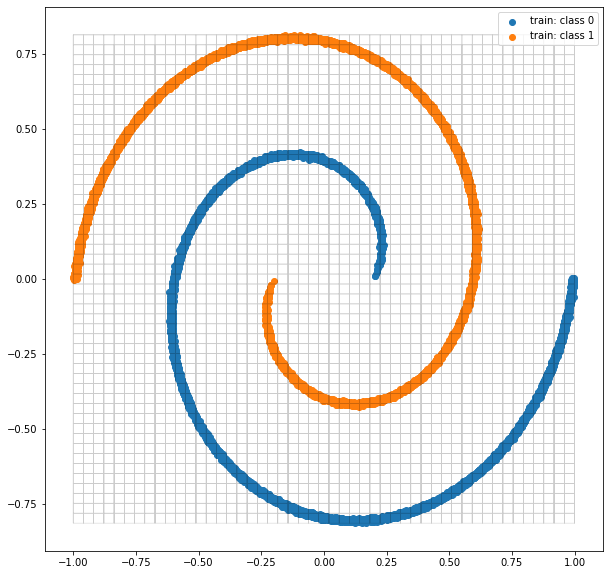

In [112]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(x_train_meshgrid[:,0], x_train_meshgrid[:,1], c="black", alpha=.2, linewidth=.5)
#ax1.scatter(x_train_meshgrid[:,0], x_train_meshgrid[:,1], c=[(.3, .3, .3, .3)], alpha=.5, s=5.)

ax1.scatter(x_train[y_train==0,0], x_train[y_train==0,1], c='C0', label="train: class 0")
ax1.scatter(x_train[y_train==1,0], x_train[y_train==1,1], c='C1', label="train: class 1")
#ax1.axis('off')
ax1.legend()
fig.show()

## Load models

### VAE

In [41]:
vae_run_id = 5935

In [42]:
vae = vari.models.VariationalAutoencoder(x_dim=2, z_dim=2, h_dims=[64, 64, 64])
vae.load_state_dict(torch.load(
    os.path.join(experiments_dir, str(vae_run_id), 'model_state_dict.pkl'),
    map_location=torch.device('cpu')
))

<All keys matched successfully>

### AVAE

In [43]:
avae_run_id = 5934

In [44]:
avae = vari.models.AuxilliaryVariationalAutoencoder(x_dim=2, z_dim=2, a_dim=3, h_dims=[64, 64, 64])
avae.load_state_dict(torch.load(
    os.path.join(experiments_dir, str(avae_run_id), 'model_state_dict.pkl'),
    map_location=torch.device('cpu')
))

<All keys matched successfully>

In [45]:
models = dict(
    vae=vae,
    avae=avae
)

## Visualize latent space

In [103]:
def plot_vectors_and_mesh(vectors, mesh, fig=None, ax=None, figsize=(20, 20), label_ids=None):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)
        
    if label_ids is not None:
        ax.scatter(vectors[label_ids==0, 0], vectors[label_ids==0, 1], c='C0', alpha=0.4, label="train:class0")
        ax.scatter(vectors[label_ids==1, 0], vectors[label_ids==1, 1], c='C1', alpha=0.4, label="train:class1")
    else:
        ax.scatter(vectors[:,0], vectors[:,1], c='C0', alpha=0.4, label="train")
    #ax1.scatter(vae_qz_mu_x2[:,0], vae_qz_mu_x2[:,1], c=[test1_0], alpha=0.4, label="test1")
    ax.plot(mesh[:,0], mesh[:,1], c='black', alpha=.2, linewidth=.5)
    ax.scatter(mesh[:,0], mesh[:,1], c=[(.8, .8, .8, .8)], alpha=.5, s=5.)
    # ax1.axis('off')
    ax.legend()
    return fig, ax

In [104]:
y_train

array([1, 0, 1, ..., 0, 0, 1])

### VAE

In [113]:
with torch.no_grad():
    vae_qz_x_train, vae_qz_mu_x_train, vae_qz_log_var_x_train = vae.decoder(torch.FloatTensor(train_dataset.examples))
    vae_qz_mesh, vae_qz_mu_mesh, vae_qz_log_var_mesh = vae.decoder(torch.FloatTensor(x_train_meshgrid_large))

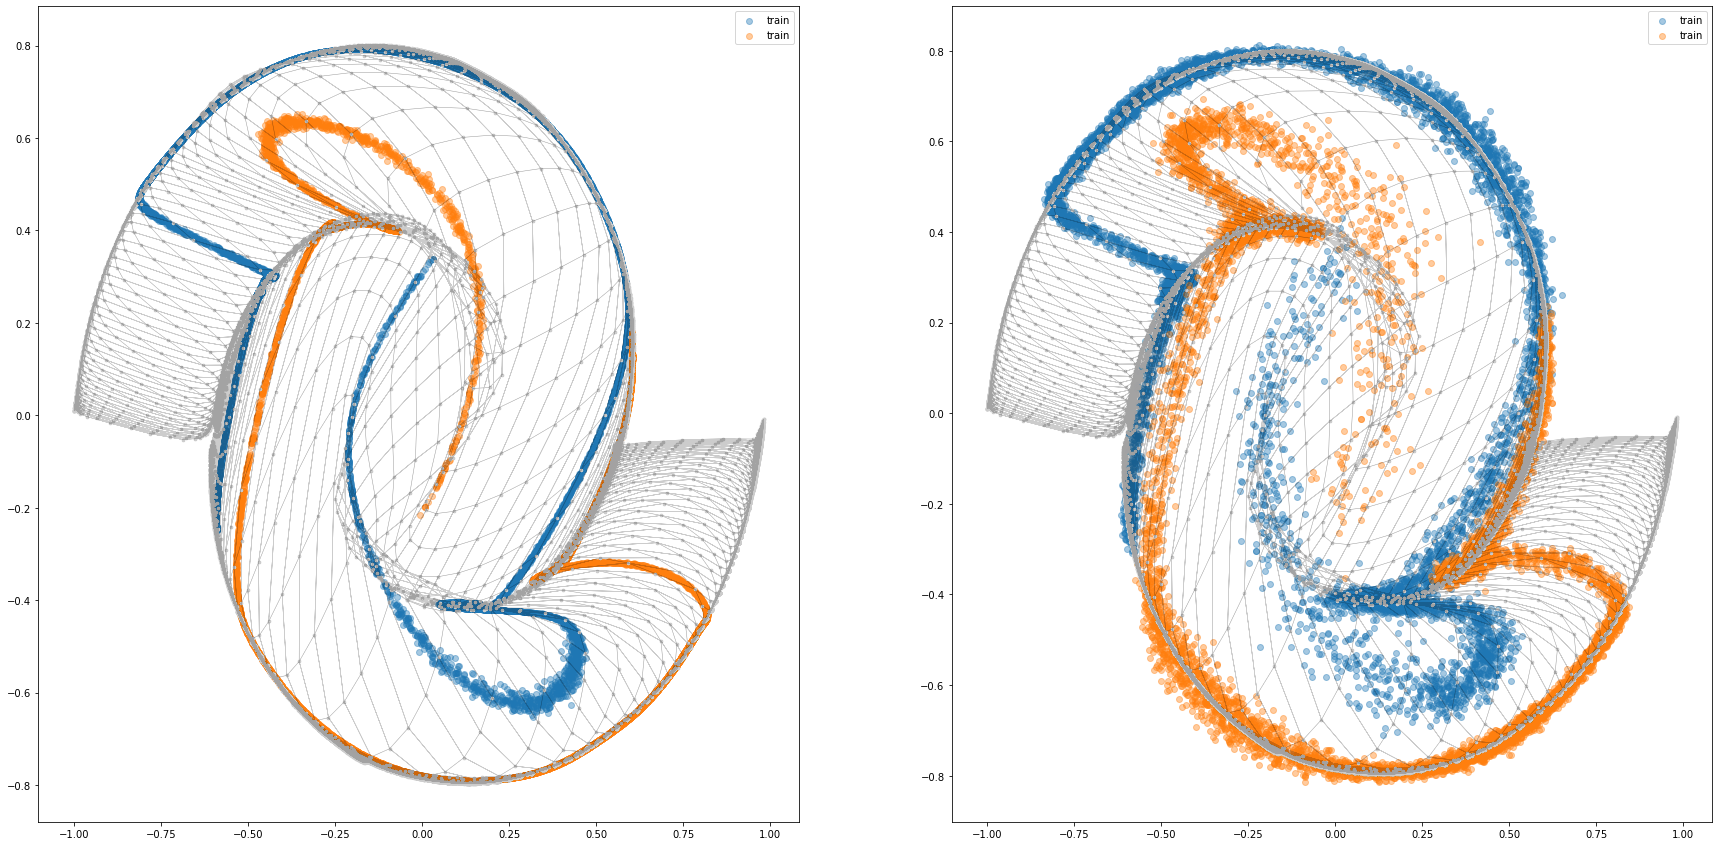

In [114]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
plot_vectors_and_mesh(vae_qz_mu_x_train, vae_qz_mu_mesh, label_ids=y_train, ax=ax1)
plot_vectors_and_mesh(vae_qz_x_train, vae_qz_mu_mesh, label_ids=y_train, ax=ax2)
plt.show()

### AVAE

In [84]:
with torch.no_grad():
    avae_qz_x_train, avae_qz_mu_x_train, avae_qz_log_var_x_train = avae.decoder(torch.FloatTensor(train_dataset.examples))
    avae_qz_mesh, avae_qz_mu_mesh, avae_qz_log_var_mesh = avae.decoder(torch.FloatTensor(x_train_meshgrid))

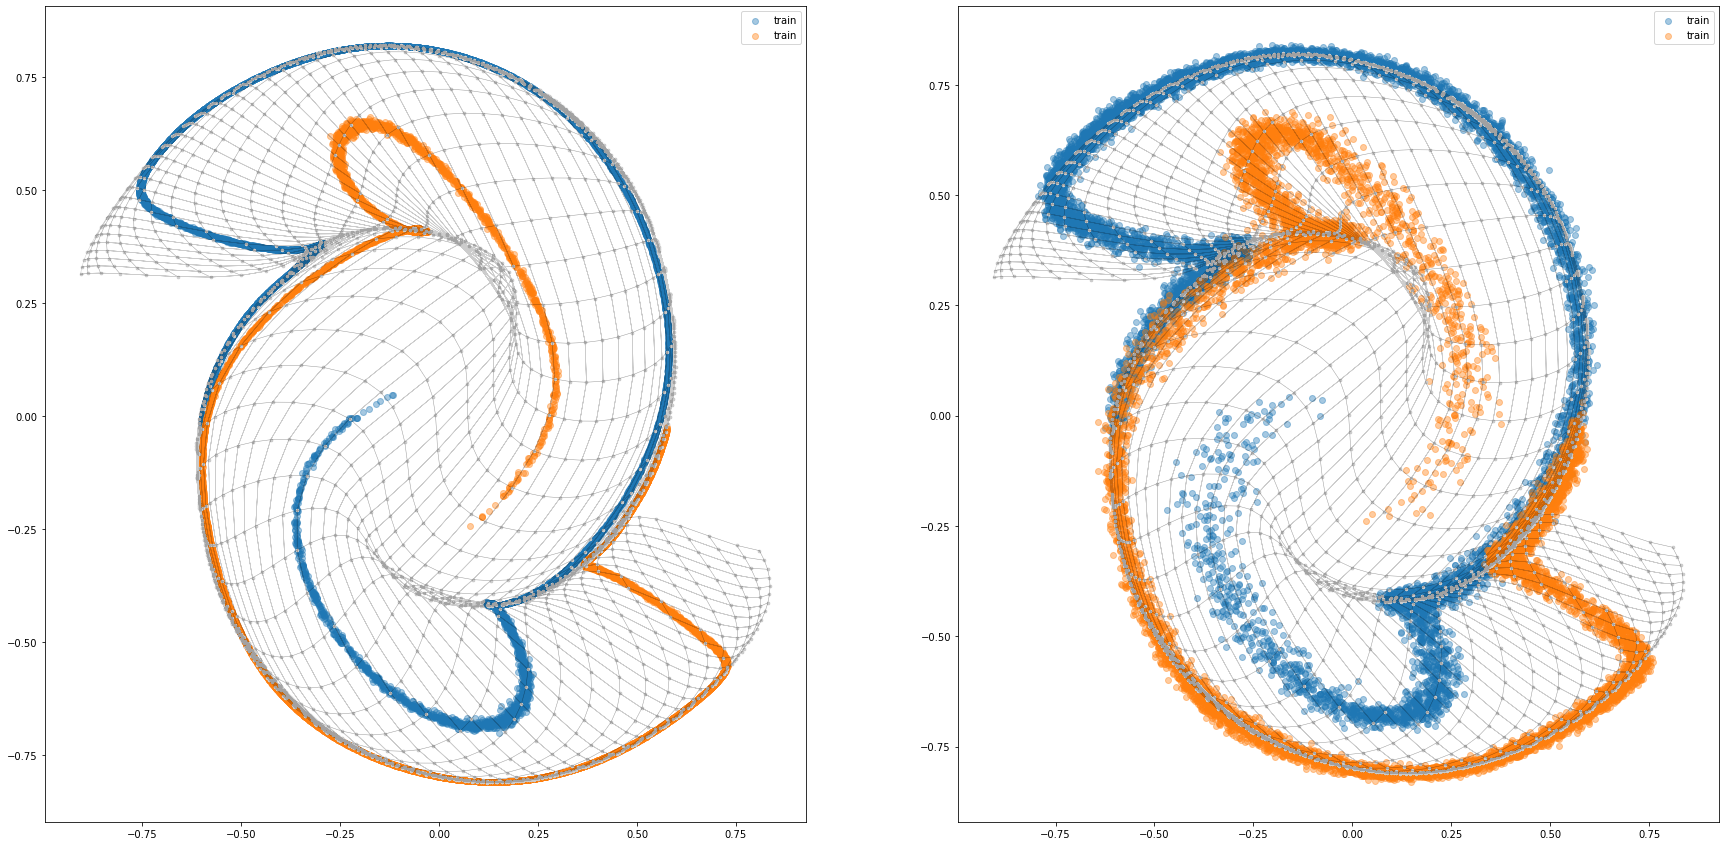

In [131]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
plot_vectors_and_mesh(avae_qz_mu_x_train, avae_qz_mu_mesh, label_ids=y_train, ax=ax1)
plot_vectors_and_mesh(avae_qz_x_train, avae_qz_mu_mesh, label_ids=y_train, ax=ax2)
plt.show()

## Visualize sampling

In [134]:
n_samples = 10000
p_z_samples = torch.randn((n_samples, 2))

In [135]:
with torch.no_grad():
    vae_p_x_samples, vae_p_x_mu, vae_p_x_log_var = vae.decoder(p_z_samples)
    avae_p_x_samples, avae_p_x_mu, avae_p_x_log_var = avae.decoder(p_z_samples)

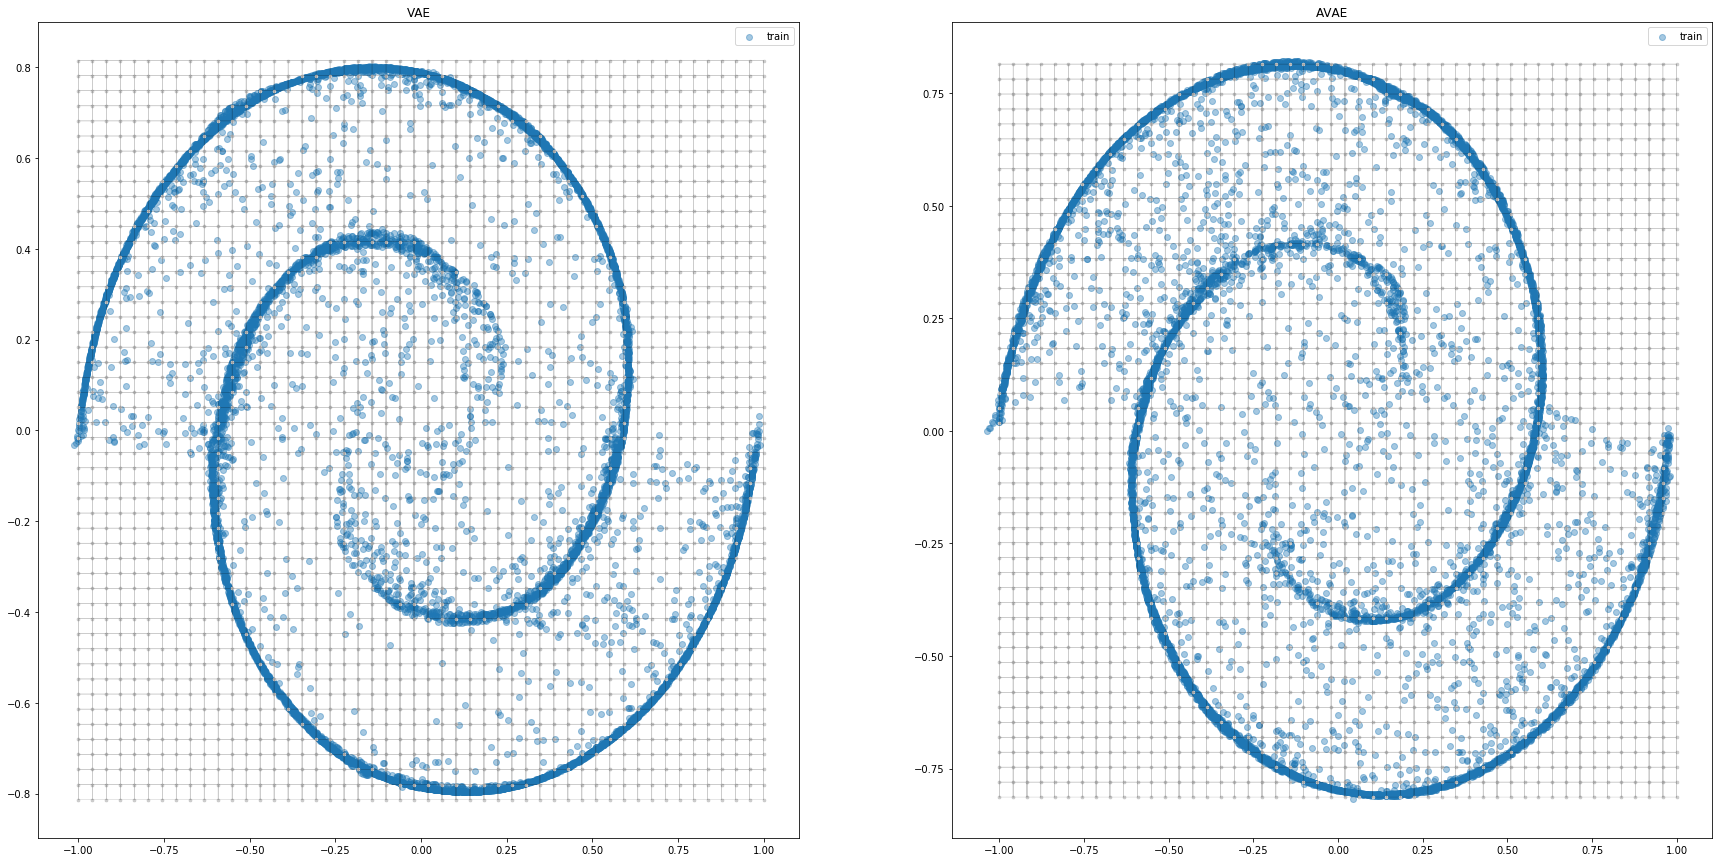

In [138]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
plot_vectors_and_mesh(vae_p_x_mu, x_train_meshgrid, ax=ax1)
plot_vectors_and_mesh(avae_p_x_mu, x_train_meshgrid, ax=ax2)
ax1.set_title('VAE')
ax2.set_title('AVAE')
plt.show()